# Refactor Network Charts 

Refactor network charts code to place geometry placement code in its own "mixin"...

In [1]:
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dmt.tk.plotting.shapes import Circle, Arc, PolarPoint
from dmt.tk.plotting.charts.network import CircularNetworkChart

In [2]:
N = 6
mtypes = ["L23_MC", "L5_TPC:A", "L6_UPC", "L23_BC", "L1_SBC", "L4_TPC"][:N]
sclasses = pd.Series(
    ["INH", "EXC", "EXC", "INH", "INH", "EXC"][:N],
    index=mtypes, name="sclass")
pathways = [
    (pre_mtype, post_mtype)
    for pre_mtype in mtypes
    for post_mtype in mtypes]
N = len(pathways)
pathway_strength = pd.DataFrame(
    {("pathway_strength", "mean"): np.random.uniform(size=N),
     ("pathway_strength", "std"):  np.random.uniform(size=N)},
    index=pd.MultiIndex.from_tuples(
        pathways,
        names=["pre_mtype", "post_mtype"]))
def get_node_weights(dataframe):
    weights = dataframe.groupby("pre_mtype").agg("sum")[("pathway_strength", "mean")]
    weights.index.name = "label"
    weights.name = "weight"
    return weights/np.sum(weights)

link_weights = pd.Series(
    pathway_strength[("pathway_strength", "mean")].values,
    index = pathway_strength.index.rename(["begin_node", "end_node"]),
    name="weight")

In [3]:
layer_cols = {'L1': np.array([0.3, 0.3, 0]),
              'L2': np.array([0.0, 0.3, 0.3]),
              'L3': np.array([0.15, 0.3, 0.15]),
              'L4': np.array([0.3, 0.0, 0.3]),
              'L5': np.array([0.0, 0.6, 0.0]),
              'L6': np.array([0.1, 0.1, 0.4])}
layer_cols["L23"] = (layer_cols["L2"] + layer_cols["L3"]) / 2.

default = np.array([0.2, 0.2, 0.2])
add_ei = {'EXC': np.array([0.5, 0.0, 0.0]),
          'INH': np.array([0.0, 0.0, 0.5])}


def _get_color(mtype, sclass):
    layer = mtype.split('_')[0]
    return np.minimum(
        layer_cols[layer]
            + add_ei[sclass] 
            + np.random.rand(3) * 0.25, 1.0)
def make_col_dict(mtypes):
    return dict([(_m[0], numpy.minimum(layer_cols.setdefault(_m[0][1], default)
                                       + add_ei[_m[1]] +
                                       numpy.random.rand(3) * 0.25, 1.0))
                 for _m in mtypes])

In [4]:
mtypes = link_weights.index.get_level_values("begin_node").unique()
color_map ={
    mtype: _get_color(mtype, sclass)
    for mtype, sclass in sclasses.items()}
for pre in mtypes:
    for post in mtypes:
        link_color = list(color_map[pre])
        link_color.append(0.25)
        color_map[(pre, post)] = np.array([0.8, 0.8, 0.8, 1.0]) * link_color
chart =\
    CircularNetworkChart(
        link_data=link_weights,
        color_map=color_map)

In [5]:
chart.link_data.groupby(
    "begin_node"
).agg(
    "sum"
).rename(
    "outgoing"
)

begin_node
L1_SBC      2.070847
L23_BC      4.338429
L23_MC      3.442064
L4_TPC      3.447526
L5_TPC:A    2.018557
L6_UPC      2.213626
Name: outgoing, dtype: float64

In [6]:
chart.node_flow

,outgoing,incoming,total
L1_SBC,2.070847,2.591916,4.662763
L23_BC,4.338429,2.481029,6.819458
L23_MC,3.442064,3.836973,7.279037
L4_TPC,3.447526,1.867827,5.315352
L5_TPC:A,2.018557,2.458972,4.477529
L6_UPC,2.213626,4.294332,6.507958


In [7]:
chart.node_weight

,total,source,target
L1_SBC,0.132986,0.059062,0.073924
L23_BC,0.194497,0.123736,0.070761
L23_MC,0.207604,0.098171,0.109434
L4_TPC,0.151598,0.098326,0.053272
L5_TPC:A,0.127703,0.057571,0.070132
L6_UPC,0.185612,0.063134,0.122478


In [8]:
chart.node_position

,source,target
L1_SBC,"(1.0, 0.13916219871445515)","(0.9, 0.45250274366124765)"
L23_BC,"(1.0, 1.180025551143635)","(0.9, 1.6382973214573013)"
L23_MC,"(1.0, 2.298132225497458)","(0.9, 2.787287995079094)"
L4_TPC,"(1.0, 3.538610186009349)","(0.9, 3.8958051333396835)"
L5_TPC:A,"(1.0, 4.418771883757206)","(0.9, 4.719664596210376)"
L6_UPC,"(1.0, 5.29546546065606)","(0.9, 5.732804206222805)"


In [9]:
chart.node_geometry_size.total

L1_SBC       (0.1, 0.626681089893585)
L23_BC      (0.1, 0.9165435406273326)
L23_MC      (0.1, 0.9783115391632726)
L4_TPC      (0.1, 0.7143898946606686)
L5_TPC:A    (0.1, 0.6017854249063418)
L6_UPC      (0.1, 0.8746774911334889)
Name: total, dtype: object

In [10]:
node_one = chart.node_data.iloc[0]
node_one.position.source

(1.0, 0.13916219871445515)

In [11]:
PolarPoint(
    *node_one.position.source)

PolarPoint(radial=1.0, angular=0.13916219871445515)

In [12]:
chart.get_source_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

In [13]:
chart.get_target_geometry("L1_SBC", chart.node_data.loc["L1_SBC"])

<Figure size 1008x1008 with 0 Axes>

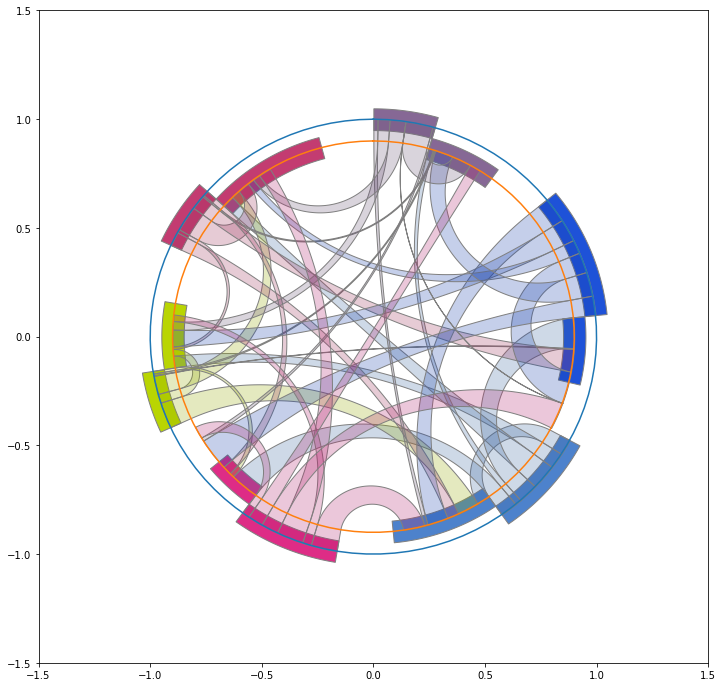

In [14]:
figure = plt.figure(figsize=(14, 14))
axes = figure.add_axes()
chart.draw(draw_diagonal=False)

In [36]:
from collections import OrderedDict
flows = list(chart.flow_geometries.values())
flow_size = pd.DataFrame(
    [
        OrderedDict([("begin", flow.size_begin),("end", flow.size_end)])
        for flow in chart.flow_geometries.values()
    ],
    index=pd.MultiIndex.from_tuples(
        [flow.label for flow in chart.flow_geometries.values()],
        names=["begin_node", "end_node"])
)
print(chart.node_geometry_size.loc["L6_UPC"].target[1])
flow_size.xs(
    "L6_UPC", level="end_node"
)

0.5771634263152603


,begin,end
begin_node,,
L23_MC,0.117235,0.060432
L5_TPC:A,0.085304,0.043972
L6_UPC,0.117808,0.060727
L23_BC,0.063786,0.032880
L1_SBC,0.071339,0.036774
L4_TPC,0.121692,0.062729


In [38]:
chart.flow_data.xs(
    "L6_UPC", level="end_node")

,weight,begin,end
begin_node,,,
L23_MC,0.049756,0.117235,0.060432
L5_TPC:A,0.036204,0.085304,0.043972
L6_UPC,0.049999,0.117808,0.060727
L23_BC,0.027072,0.063786,0.032880
L1_SBC,0.030277,0.071339,0.036774
L4_TPC,0.051648,0.121692,0.062729


In [16]:
def _angular_size(dataframe):
    return dataframe.apply(
        lambda row: pd.Series(dict(
            source = row.source[1],
            target = row.target[1])),
        axis=1
    )
posize = pd.concat(
    [_angular_size(chart.node_position),
     _angular_size(chart.node_geometry_size)],
    axis=1,
    keys=["position", "geometry_size"]
)
posize

position           geometry_size          
            source    target        source    target
L1_SBC    0.139162  0.452503      0.278324  0.348357
L23_BC    1.180026  1.638297      0.583090  0.333453
L23_MC    2.298132  2.787288      0.462618  0.515694
L4_TPC    3.538610  3.895805      0.463352  0.251038
L5_TPC:A  4.418772  4.719665      0.271297  0.330489
L6_UPC    5.295465  5.732804      0.297514  0.577163

In [17]:
chart.flow_size.head()

AttributeError: 'CircularNetworkChart' object has no attribute 'flow_size'

In [ ]:
figure

In [ ]:
chart.node_geometry_size.source

In [ ]:
l23_MC = chart.source_geometries["L23_MC"]
l23_MC.shape

In [ ]:
chart.node_data.geometry_size.loc["L23_MC"].source

In [ ]:
chart.center

In [ ]:
l23mc =  chart.source_geometries["L23_MC"]

In [ ]:
l23mc.shape.radial

In [ ]:
l23mc.shape.angular

In [ ]:
chart.get_source_geometry(
    "L23_MC",
    chart.node_data.loc["L23_MC"]
).shape

In [ ]:
chart.node_data.loc["L23_MC"]

In [ ]:
PolarPoint(*chart.node_data.loc["L23_MC"].position.source)

In [ ]:
chart.node_geometry_size

In [ ]:
chart.node_geometry_size.apply(
    lambda s: pd.Series(dict(total=s.total[1], source=s.source[1], target=s.target[1])),
    axis=1)

In [ ]:
chart.node_position

In [ ]:
 number_nodes = chart.node_weight.shape[0]
 spacing = 2. * np.pi * chart.spacing_factor / number_nodes

 def _positions_angular():
     position_end = - spacing
     for size in chart.node_geometry_size.total.values:
         position_start = position_end + spacing
         position_end = position_start + size[1]
         yield (position_start + position_end) / 2.

positions_angular = pd.Series(
    list(_positions_angular()),
        index=chart.node_geometry_size.index,
        name="angular"
)
node_geometry_size_angular = chart.node_geometry_size.apply(
    lambda node_size: pd.Series(dict(
        total=node_size.total[1],
        source=node_size.source[1],
        target=node_size.target[1])),
        axis=1
)
starts_source = (
    positions_angular - node_geometry_size_angular.total[1] / 2.
).rename(
    "start_source"
)
positions_angular_source = (
    starts_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "angular"
)
positions_source = positions_angular_source.apply(
    lambda position_angular: (chart.outer_circle.radius, position_angular)
)
starts_target = (
    positions_angular_source + node_geometry_size_angular.source[1] / 2.
).rename(
    "start_target"
)
positions_angular_target = (
    starts_target + node_geometry_size_angular.target[1] / 2.
).rename(
    "angular"
)
positions_target = positions_angular_target.apply(
    lambda position_angular: (
        chart.inner_circle.radius, position_angular)
)

In [ ]:
positions_target